In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
import regex as reg
import unicodedata
import os, re, json, html, base64
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div style="background:#f0f8ff; padding:12px; border-radius:6px">
Lancement de la fonction info pour consulter les colonnes.
</div>

In [102]:
exploration = '/content/drive/MyDrive/exploration.csv'
df=pd.read_csv(exploration)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84546 entries, 0 to 84545
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   productid                84546 non-null  int64 
 1   prdtypecode              84546 non-null  int64 
 2   designation              84546 non-null  object
 3   description              54793 non-null  object
 4   image                    84546 non-null  object
 5   cleaned_designation      84546 non-null  object
 6   cleaned_description      54668 non-null  object
 7   text                     84546 non-null  object
 8   hashed_image             84546 non-null  object
 9   category                 84546 non-null  object
 10  group                    84546 non-null  object
 11  cleaned_description_len  84546 non-null  int64 
 12  is_label_issue           84546 non-null  bool  
 13  detected_lang            84546 non-null  object
 14  near_duplicated          84546 non-nul

Ajout d'une colonne "text_clean" contenant le titre et la description produit.

In [105]:
df["text_clean"] = (
    df["cleaned_designation"].fillna("") + " " +
    df["cleaned_description"].fillna(""))

df[["cleaned_designation", "cleaned_description", "text_clean"]].head()

,cleaned_designation,cleaned_description,text_clean
0,olivia: personalisiertes notizbuch 150 seiten ...,NaN,olivia: personalisiertes notizbuch 150 seiten ...
1,journal des arts (le) n° 133 du 28/09/2001 l'a...,NaN,journal des arts (le) n° 133 du 28/09/2001 l'a...
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen de marque speedlink est ...,grand stylet ergonomique bleu gamepad nintendo...
3,peluche donald europe disneyland 2000 (marionn...,NaN,peluche donald europe disneyland 2000 (marionn...
4,la guerre des tuques,luc a des idées de grandeur il veut organiser ...,la guerre des tuques luc a des idées de grande...


#  1. Analyse du nombre de chiffres présent par catégories


Objectif: compter le nombre de chiffres présent en moyenne dans chaque catégorie afin de savoir si les produits sont décrits plutôt avec des phrases ou avec des chiffres (tailles, dimensions, références etc.) et de mesurer el niveau de technicité d'une catégorie.



In [106]:
def count_digits(text):
    """
    Compte le nombre de chiffres (0-9) dans une chaîne de caractères.
    """

    compteur = 0
    for caractere in text:
        if caractere.isdigit():
            compteur = compteur + 1
    return compteur

df["nb_digits_text"] = df["text_clean"].apply(count_digits)

df[["text_clean", "nb_digits_text"]].head(10)


,text_clean,nb_digits_text
0,olivia: personalisiertes notizbuch 150 seiten ...,4
1,journal des arts (le) n° 133 du 28/09/2001 l'a...,11
2,grand stylet ergonomique bleu gamepad nintendo...,5
3,peluche donald europe disneyland 2000 (marionn...,4
4,la guerre des tuques luc a des idées de grande...,0
5,afrique contemporaine n° 212 hiver 2004 dossie...,7
6,christof e: bildungsprozessen auf der spur,0
7,conquérant sept cahier couverture polypro 240 ...,30
8,puzzle scooby-doo avec poster 2x35 pieces,3
9,tente pliante v3s5-pro pvc blanc 3 x 4m50 long...,81


Savoir combien il y a de chiffres dans les textes produits permettra de savoir

*   si la feature "nb_digits_text" est pertinente à prendre en compte,
*   quelles sont les catégories qui ont le plus de chiffres..



In [107]:
target_col = "category"

liste_categories = df[target_col].unique()

resultats = []

for cat in sorted(liste_categories):
    sous_df = df[df[target_col] == cat]
    moyenne = sous_df["nb_digits_text"].mean()
    mediane = sous_df["nb_digits_text"].median()
    minimum = sous_df["nb_digits_text"].min()
    maximum = sous_df["nb_digits_text"].max()

    resultats.append({
        "category": cat,
        "mean_nb_digits": moyenne,
        "median_nb_digits": mediane,
        "min_nb_digits": minimum,
        "max_nb_digits": maximum
    })

stats_digits = pd.DataFrame(resultats)

stats_digits = stats_digits.sort_values("mean_nb_digits", ascending=False)

stats_digits.head(15)


,category,mean_nb_digits,median_nb_digits,min_nb_digits,max_nb_digits
8,Jeux PC en Téléchargement,46.542431,35.0,0,268
17,Modélisme & Drones,35.479100,21.0,0,824
18,Piscine & Accessoires,34.013627,17.0,0,531
2,Bricolage & Outillage,30.963321,19.0,0,3288
1,Animaux,25.240583,15.0,0,737
6,Décoration & Équipement Jardin,22.064884,17.0,0,194
5,Décoration & Lumières,21.719439,15.0,0,1185
26,Équipement Maison,21.234005,16.0,0,389
23,Textiles d'intérieur,17.474076,15.0,0,191
16,Loisirs & Plein air,16.241435,11.0,0,173


Nous constatons que les moyennes sont très differentes en fonction des catégories (46.5 pour les jeux PC en téléchargement contre 15 pour la catégorie Bureau&Papeterie) donc "nb_digits_text" est bien une feature discriminantes.

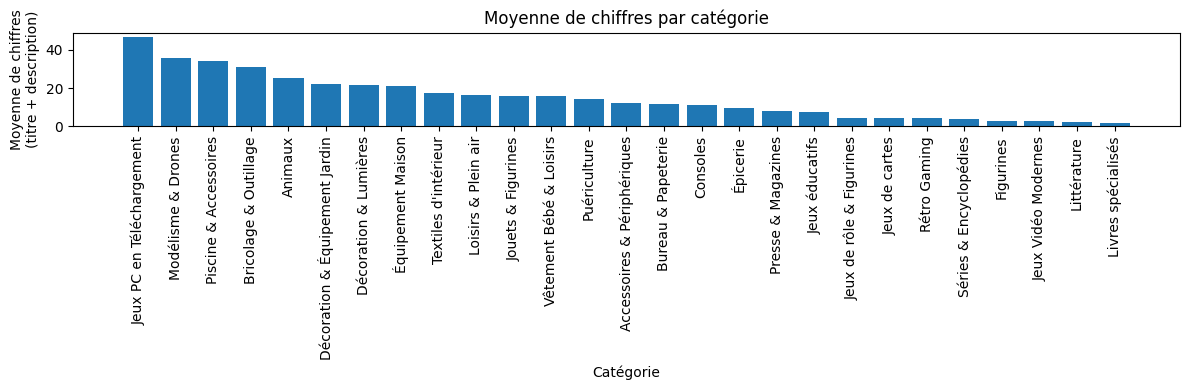

In [62]:
plt.figure(figsize=(12, 4))

plt.bar(
    stats_digits["category"].astype(str),
    stats_digits["mean_nb_digits"]
)

plt.xlabel("Catégorie")
plt.ylabel("Moyenne de chiffres\n(titre + description)")
plt.title("Moyenne de chiffres par catégorie")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Les catégories contenant le plus de chiffres (Jeux PC en téléchargement, Modélisme&Drone) contiennent généralement des références techniques, produit, tailles de fichiers, version ou encore des dimensions.

Les catégories contenant le moins de chiffres ont des description axées litterature (Livres spécialisés, Littérature).


# 2. Recherche d'unités par catégories

Maintenant, nous allons rechercher la présences d'unités pour améliorer la compréhension du texte par le modèle. Nous mettons donc en place le dictionnaire regex.

In [108]:

unit_patterns = {
    # Dimensions
    "cm":   r"\b\d+\s*(cm|centimetre?s?|centimètre?s?)\b",
    "mm":   r"\b\d+\s*(mm|millimetre?s?|millimètre?s?)\b",
    "m":    r"\b\d+\s*(m|metre?s?|mètre?s?)\b",

    # Poids
    "kg":   r"\b\d+\s*(kg|kilo|kilogramme?s?)\b",
    "g":    r"\b\d+\s*(g|gramme?s?)\b",

    # Volume
    "ml":   r"\b\d+\s*(ml|millilitres?|millilitre?)\b",
    "l":    r"\b\d+\s*(l|litres?|litre?)\b",
    "cl":   r"\b\d+\s*cl\b",  # ex : 50cl

    # Dimensions éventuellement suivies d'une unité
    "x_dim": r"\b\d+\s*(x|×)\s*\d+(\s*(cm|mm|m))?\b",

    # Âge
    "age_ans":  r"\b\d+\s*ans\b",
    "age_mois": r"\b\d+\s*mois\b",

    # Pouces (écrans, certains produits tech)
    "inch": r'\b\d+\s*(\"|pouces?|po)\b',
}

compiled_patterns = []
for pattern in unit_patterns.values():
    regex_obj = re.compile(pattern, flags=re.IGNORECASE)
    compiled_patterns.append(regex_obj)


In [116]:
def detect_any_unit(text, list_of_regex):
    """
    Retourne 1 si le texte contient au moins une unité (parmi la liste de regex),
    sinon 0.
    """
    text = str(text)

    for regex_pattern in list_of_regex:
        if regex_pattern.search(text):
            return 1
    return 0



In [117]:
df["has_any_unit"] = df["text_clean"].apply(
    lambda txt: detect_any_unit(txt, compiled_patterns)
)

df[["text_clean", "has_any_unit"]].head(10)


,text_clean,has_any_unit
0,olivia: personalisiertes notizbuch 150 seiten ...,0
1,journal des arts (le) n° 133 du 28/09/2001 l'a...,1
2,grand stylet ergonomique bleu gamepad nintendo...,0
3,peluche donald europe disneyland 2000 (marionn...,0
4,la guerre des tuques luc a des idées de grande...,0
5,afrique contemporaine n° 212 hiver 2004 dossie...,0
6,christof e: bildungsprozessen auf der spur,0
7,conquérant sept cahier couverture polypro 240 ...,1
8,puzzle scooby-doo avec poster 2x35 pieces,1
9,tente pliante v3s5-pro pvc blanc 3 x 4m50 long...,1


Ici, on cherche à savoir dans chaque catégorie, quel pourcentage de produits contient au moins une unité.

In [119]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    taux_unites = sous_df["has_any_unit"].mean()
    pourcentage = taux_unites * 100

    resultats.append({
        "categorie": cat,
        "nb_products": nb_produits,
        "pct_products_with_unit": pourcentage
    })

stats_units_any = pd.DataFrame(resultats)

# Affichage des catégories par pourcentage décroissant
stats_units_any = stats_units_any.sort_values(
    "pct_products_with_unit",
    ascending=False
)

stats_units_any.head(20)


,categorie,nb_products,pct_products_with_unit
23,Textiles d'intérieur,4301,89.955824
26,Équipement Maison,5064,85.248815
1,Animaux,823,82.503038
5,Décoration & Lumières,4990,81.242485
6,Décoration & Équipement Jardin,2543,81.124656
25,Épicerie,803,77.459527
18,Piscine & Accessoires,9980,73.256513
24,Vêtement Bébé & Loisirs,790,72.784810
2,Bricolage & Outillage,2481,72.188634
16,Loisirs & Plein air,2481,69.085046


Nous constatons que la catégorie "Textiles d'intérieur" contient quasi systématiquement des mesures(90%) contrairement à d'autres comme Jeux de rôle& Figurines(15%). La feature "has_any_unit" est donc très caractéristique.

Affichage de toutes les catégories en fonction du nombre d'unités quelles possèdent

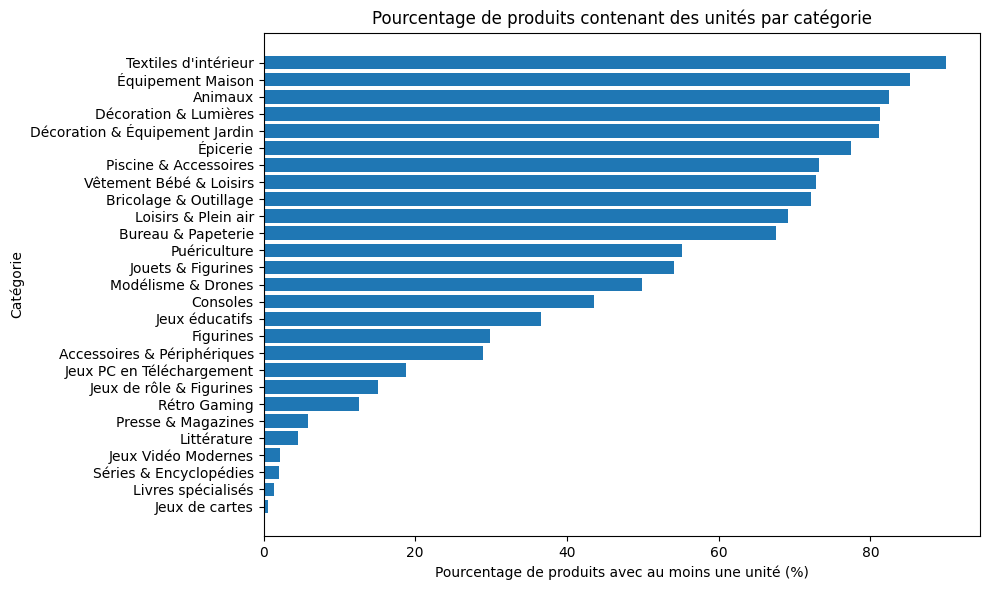

In [115]:
plt.figure(figsize=(10, 6))


plot_df = stats_units_any.sort_values("pct_products_with_unit", ascending=True)

plt.barh(
    plot_df["categorie"].astype(str),
    plot_df["pct_products_with_unit"]
)

plt.xlabel("Pourcentage de produits avec au moins une unité (%)")
plt.ylabel("Catégorie")
plt.title("Pourcentage de produits contenant des unités par catégorie")
plt.tight_layout()
plt.show()


Nous constatons que les catégories se distinguent bien:

*   Vêtement Bébé & Loisirs (73 %), cohérent avec les âges (ans, mois) et parfois dimensions.
*   Bricolage & Outillage (72 %),  mm, cm, W, V, etc., très cohérent également.


# 3. Combinaison du nombre de chiffres et des unités par catégorie

In [123]:
target_col = "category"

liste_categories = sorted(df[target_col].unique())

resultats_cat = []

for cat in liste_categories:
    sous_df = df[df[target_col] == cat]

    nb_produits = len(sous_df)
    if nb_produits == 0:
        continue

    mean_nb_digits = sous_df["nb_digits_text"].mean()


    taux_unites = sous_df["has_any_unit"].mean()
    pct_with_unit = taux_unites * 100

    resultats_cat.append({
        "category": cat,
        "nb_products": nb_produits,
        "mean_nb_digits": mean_nb_digits,
        "pct_with_unit": pct_with_unit
    })

stats_cat = pd.DataFrame(resultats_cat)

stats_cat.head()


,category,nb_products,mean_nb_digits,pct_with_unit
0,Accessoires & Périphériques,1676,12.160501,28.937947
1,Animaux,823,25.240583,82.503038
2,Bricolage & Outillage,2481,30.963321,72.188634
3,Bureau & Papeterie,4988,11.832197,67.522053
4,Consoles,829,10.993969,43.546441


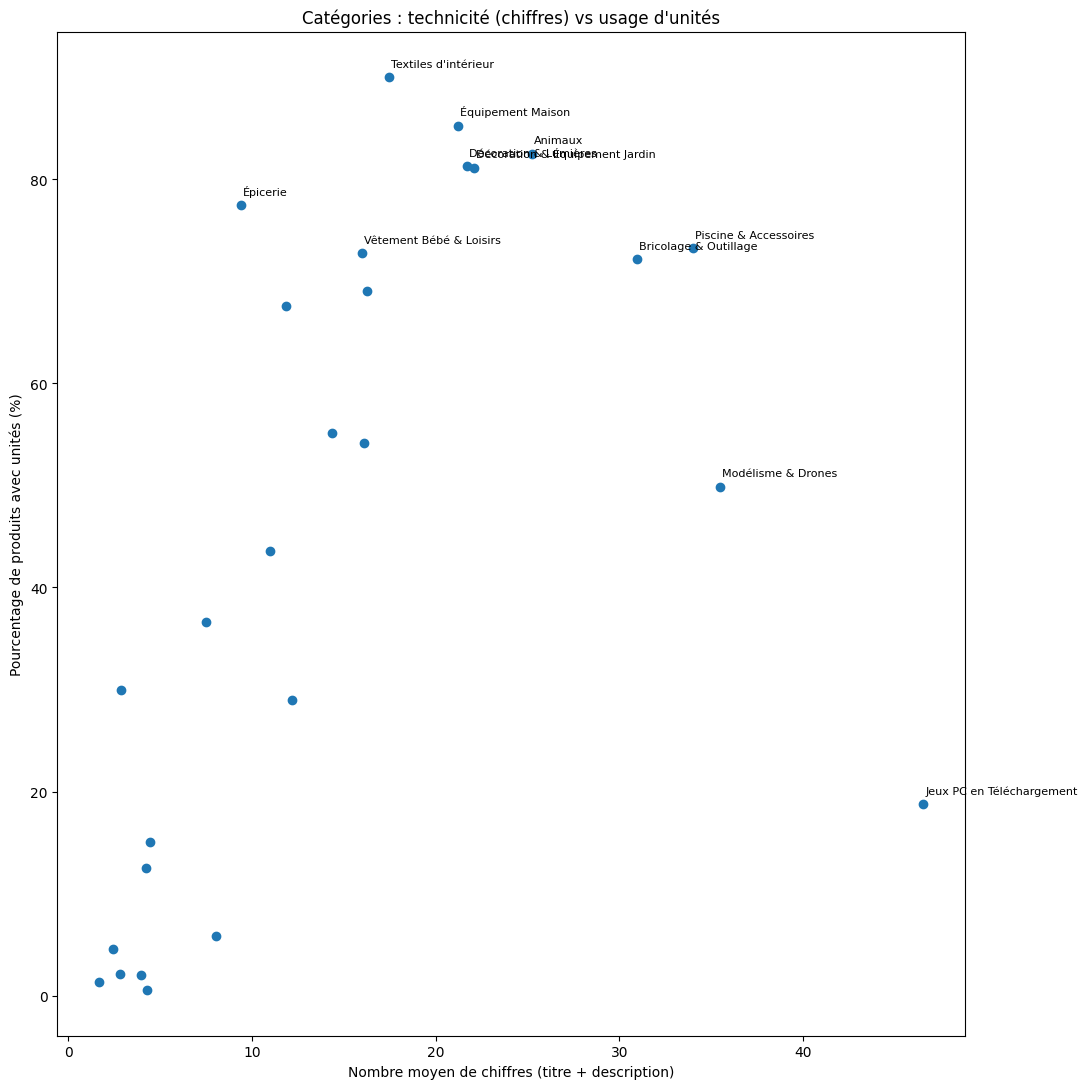

In [125]:
plt.figure(figsize=(11, 11))

plt.scatter(
    stats_cat["mean_nb_digits"],
    stats_cat["pct_with_unit"]
)

plt.xlabel("Nombre moyen de chiffres (titre + description)")
plt.ylabel("Pourcentage de produits avec unités (%)")
plt.title("Catégories : technicité (chiffres) vs usage d'unités")

seuil_pct = 70
seuil_digits = stats_cat["mean_nb_digits"].quantile(0.9)

for _, row in stats_cat.iterrows():
    x = row["mean_nb_digits"]
    y = row["pct_with_unit"]
    nom_cat = str(row["category"])

    if (y > seuil_pct) or (x > seuil_digits):
        plt.text(x + 0.1, y + 1, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()



Plus une catégorie est technique plus elle est située vers le haut à droite. Les catégories les moins techniques sont situés vers le bas à gauche.

Les jeux PC en téléchargement ont beaucoup de chiffres et peu d'unités, cela peut correspondre à des versions, numéros de produits.

Les produits techniques comportant des souvent dimensions (piscines&accessoires, bricolage&outillage) ont des descriptions qui conrrespondent à des spécifications produits. Leur localisation correspondent bien à leur typologie.

# 4. Détection de taille, pointure et âge


Détection de taille et de pointure, On veut repérer :

tailles vêtements : S, M, L, XL, XXL

tailles chiffres : 38, 40, 42, 36-38, etc.

âges : 3 mois, 6-12 mois, 2 ans, etc.


In [135]:
# --- Tailles de vêtements ---


pattern_clothing_size = re.compile(
    r"(?:\b(?:taille|T)\s*[:\-]?\s*)?"
    r"(?:"
    r"\b(XXS|XS|S|M|L|XL|XXL)\b"
    r"|\b(3[0-9]|4[0-8]|5[0-2])\b"
    r"|\b(3[0-9]|4[0-8]|5[0-2])\s*[-/]\s*(3[0-9]|4[0-8]|5[0-2])\b"
    r")",
    flags=re.IGNORECASE
)

# --- Âges bébé / enfant / jouets ---

MONTH_VALUES = r"(0|1|3|6|12|18|24)"
YEAR_VALUES = r"(1|2|3|4|5|6|7|8|9|10|12|14|16|18)"
AGE_PLUS_VALUES = r"(3|4|5|6|7|8|9|10|12|16|18)"

pattern_age_range = re.compile(
    rf"""
    \b
    (?:de\s+|pour\s+|dès\s+|à\s+partir\s+de\s+)?       # contexte optionnel

    (                                                  # début du groupe capturé principal
        {MONTH_VALUES}\s*mois                          # 3 mois, 6 mois, 18 mois...
        |{MONTH_VALUES}\s*[-/]\s*{MONTH_VALUES}\s*mois # 0-3 mois, 3/6 mois...

        |{YEAR_VALUES}\s*ans                           # 3 ans, 7 ans, 12 ans...
        |{YEAR_VALUES}\s*[-/]\s*{YEAR_VALUES}\s*ans    # 3-5 ans, 8-12 ans...

        |{AGE_PLUS_VALUES}\s*\+\s*(ans)?               # 3+ ans, 7+, 18+...
    )
    \b
    """,
    flags=re.IGNORECASE | re.VERBOSE
)

# --- Pointures (chaussures) ---

pattern_shoe_size = re.compile(
    r"""
    (?:\bpointure\s*[:\-]?\s*)?                # 'pointure' optionnel (tu peux enlever le ? pour le rendre obligatoire)

    (?:                                        # bloc principal
        \b(1[6-9]|[2-3][0-9]|4[0-6])\b         # pointures 16–46
        |
        \b(1[6-9]|[2-3][0-9]|4[0-6])\s*[-/]\s* # ex : 24-25, 30/31
           (1[6-9]|[2-3][0-9]|4[0-6])
    )
    """,
    flags=re.IGNORECASE | re.VERBOSE
)


In [136]:
def has_size_age_or_shoe(text):
    """
    Retourne 1 si le texte contient :
    - une taille vêtement (pattern_clothing_size)
    - OU un âge bébé/enfant/jouet (pattern_age_range)
    - OU une pointure (pattern_shoe_size)
    Sinon, retourne 0.
    """
    text = str(text)

    if (
        pattern_clothing_size.search(text)
        or pattern_age_range.search(text)
        or pattern_shoe_size.search(text)
    ):
        return 1
    else:
        return 0



In [ ]:
df["has_size_age_or_shoe"] = df["product_text"].apply(has_size_age_or_shoe)


In [138]:
# Tailles vêtements
df["has_clothing_size"] = df["text_clean"].apply(
    lambda txt: has_pattern(txt, pattern_clothing_size)
)

# Âges (mois / ans)
df["has_age_range"] = df["text_clean"].apply(
    lambda txt: has_pattern(txt, pattern_age_range)
)

# Pointures (chaussures)
df["has_shoe_size"] = df["text_clean"].apply(
    lambda txt: has_pattern(txt, pattern_shoe_size)
)

# Flag global : taille vêtement OU âge OU pointure
df["has_size_age_or_shoe"] = (
    (df["has_clothing_size"] == 1)
    | (df["has_age_range"] == 1)
    | (df["has_shoe_size"] == 1)
).astype(int)

# Affichage : uniquement catégorie + flag global
df[["category", "has_size_age_or_shoe"]].head(15)


,category,has_size_age_or_shoe
0,Livres spécialisés,0
1,Presse & Magazines,1
2,Accessoires & Périphériques,1
3,Jouets & Figurines,0
4,Littérature,1
5,Presse & Magazines,0
6,Livres spécialisés,0
7,Bureau & Papeterie,0
8,Jouets & Figurines,0
9,Décoration & Équipement Jardin,1


In [141]:

stats_patterns = (
    df.groupby("category")["has_size_age_or_shoe"]
      .agg(
          nb_products="size",
          pct_with_size_age_or_shoe="mean"
      )
      .reset_index()
)


stats_patterns["pct_with_size_age_or_shoe"] *= 100

stats_patterns.head()


,category,nb_products,pct_with_size_age_or_shoe
0,Accessoires & Périphériques,1676,46.957041
1,Animaux,823,83.961118
2,Bricolage & Outillage,2481,76.501411
3,Bureau & Papeterie,4988,59.101844
4,Consoles,829,75.633293


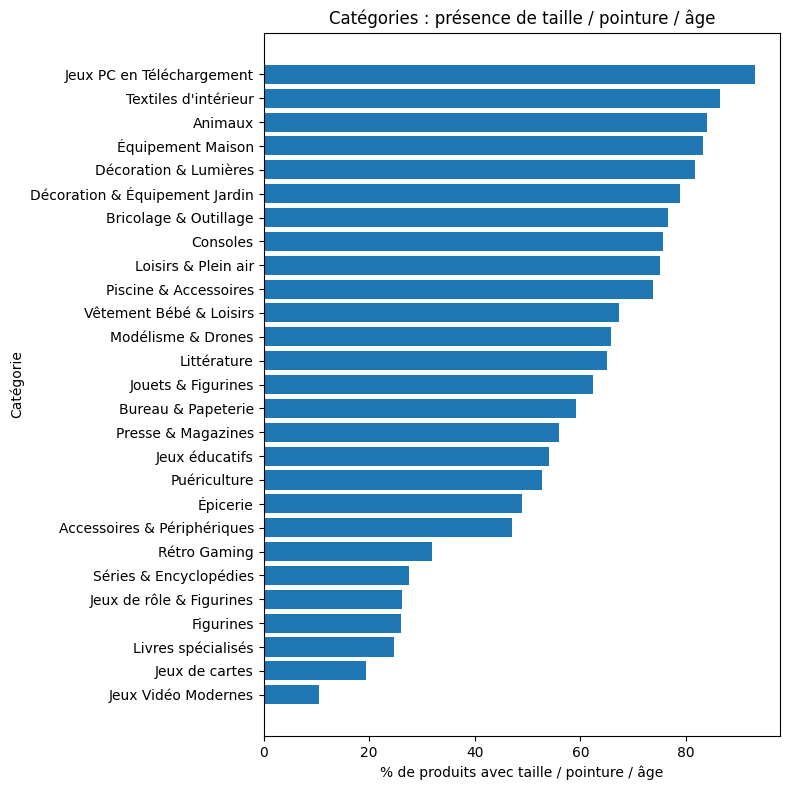

In [142]:
import matplotlib.pyplot as plt

plot_df = stats_patterns.copy()

plot_df = plot_df.sort_values("pct_with_size_age_or_shoe", ascending=True)

plt.figure(figsize=(8, 8))

plt.barh(
    plot_df["category"].astype(str),
    plot_df["pct_with_size_age_or_shoe"]
)

plt.xlabel("% de produits avec taille / pointure / âge")
plt.ylabel("Catégorie")
plt.title("Catégories : présence de taille / pointure / âge")
plt.tight_layout()
plt.show()


# Autre observation

Analyse de la relation entre taille/pointure et âge par catégorie

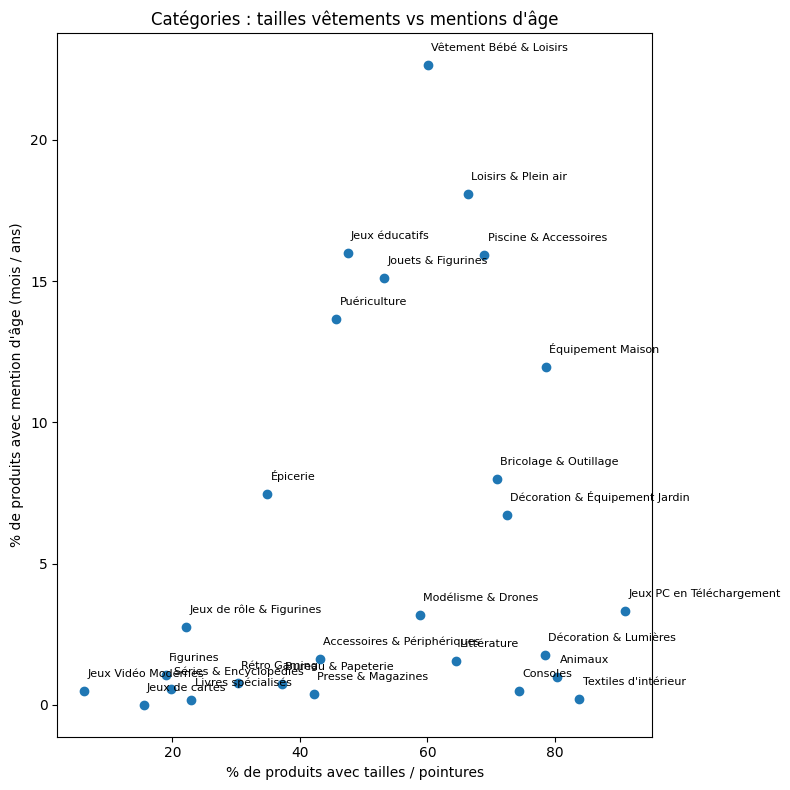

In [144]:
stats_patterns = (
    df.groupby("category")
      .agg(
          nb_products=("category", "size"),
          pct_with_clothing_size=("has_clothing_size", "mean"),
          pct_with_age_range=("has_age_range", "mean"),
      )
      .reset_index()
)

stats_patterns["pct_with_clothing_size"] *= 100
stats_patterns["pct_with_age_range"] *= 100

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.scatter(
    stats_patterns["pct_with_clothing_size"],
    stats_patterns["pct_with_age_range"]
)

plt.xlabel("% de produits avec tailles / pointures")
plt.ylabel("% de produits avec mention d'âge (mois / ans)")
plt.title("Catégories : tailles vêtements vs mentions d'âge")

for _, row in stats_patterns.iterrows():
    x = row["pct_with_clothing_size"]
    y = row["pct_with_age_range"]
    nom_cat = str(row["category"])   # on utilise la colonne 'category'

    plt.text(x + 0.5, y + 0.5, nom_cat, fontsize=8)

plt.tight_layout()
plt.show()


Les catégories contenant des produits généralement classés par âge se distinguent: vêtement bébé & loisirs, jeux éducatifs, puériculture contrairement aux catégories "animaux et  textiles d'intérieur.

En conclusion, les features dérivées des chiffres, des unités et des
mention d’âge / taille / pointure apportent une distinction forte, elles permettent de mieux séparer les familles de produits et de comprendre ce que le modèle pourra exploiter au-delà de TF-IDF.